# Text Pre-processing- Lowercasing, removing extra spaces, stopwords, punctuations

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# --- 1. CONFIGURATION ---
NUM_TRIPS = 100
GPS_READINGS_PER_TRIP = 8 # Total GPS rows: 800
TICKET_TRANSACTIONS = 900 # Total Ticketing rows: 900
COMPLAINT_RECORDS = 500 # Total Feedback rows: 500
BUS_IDS = [f'KA-01-AB-{i:04d}' for i in range(101, 106)]
ROUTES = ['R5A', 'R7C', 'R12B']
STOPS = ['Silk_Board', 'Koramangala', 'MG_Road', 'Shivaji_Nagar', 'Marathahalli', 'Whitefield']
LAT_START, LON_START = 12.97, 77.59 # Bangalore-like coordinates
CAPACITY = 60

# Base timestamp for simulation
start_date = datetime(2025, 11, 13, 7, 0, 0)

# --- 2. GENERATE TRIP IDS AND CORE TIMING ---
trip_df = pd.DataFrame({
    'Route_ID': random.choices(ROUTES, weights=[0.5, 0.3, 0.2], k=NUM_TRIPS),
    'Bus_ID': random.choices(BUS_IDS, k=NUM_TRIPS)
})
trip_df['Trip_ID'] = [f"{r}_{i+1:04d}" for i, r in enumerate(trip_df['Route_ID'])]
trip_df['Start_Time'] = [start_date + timedelta(minutes=i * 15) for i in range(NUM_TRIPS)]

# --- 3. GPS / VEHICLE LOCATION DATA (VLD.CSV) ---
gps_data = []
for index, row in trip_df.iterrows():
    trip_id = row['Trip_ID']
    bus_id = row['Bus_ID']
    start_time = row['Start_Time']
    
    # Simulate a small drift in time/location for 8 checkpoints
    for i in range(GPS_READINGS_PER_TRIP):
        scheduled_arrival = start_time + timedelta(minutes=i * 10)
        
        # Simulate delay: 30% chance of a high delay (peak traffic)
        delay = random.randint(0, 5) 
        if random.random() < 0.3:
            delay = random.randint(10, 25) # Simulate significant congestion
        
        actual_time = scheduled_arrival + timedelta(minutes=delay)
        
        # Simulate movement
        lat_change = random.uniform(0.001, 0.005) * i
        lon_change = random.uniform(0.001, 0.005) * i
        
        gps_data.append({
            'Trip_ID': trip_id,
            'Bus_ID': bus_id,
            'Timestamp': actual_time,
            'Latitude': LAT_START + lat_change,
            'Longitude': LON_START + lon_change,
            'Scheduled_Arrival': scheduled_arrival.time(),
            'Delay_Minutes': delay
        })

vld_df = pd.DataFrame(gps_data)
vld_df.to_csv('VLD_GPS_Data.csv', index=False)
print(f"Generated VLD_GPS_Data.csv with {len(vld_df)} rows.")

# --- 4. TICKETING / PASSENGER LOAD DATA (ETM.CSV) ---
etm_data = []
# Select a subset of trips to have transactions
transaction_trips = trip_df.sample(int(TICKET_TRANSACTIONS * 0.8 / 10)).reset_index(drop=True) 

for i in range(TICKET_TRANSACTIONS):
    # Link transaction to a trip
    trip_row = transaction_trips.sample(1).iloc[0] 
    trip_id = trip_row['Trip_ID']
    
    # Simulate transaction time within 90 minutes of start
    transaction_time = trip_row['Start_Time'] + timedelta(minutes=random.randint(5, 90))
    
    boarding_stop = random.choice(STOPS[:-1])
    alighting_stop = random.choice([s for s in STOPS if s != boarding_stop])
    
    fare = random.randint(10, 50)
    is_concession = random.choice([True, False, False, False]) # Lower concession rate
    
    # Simulate passenger load accumulation
    current_load = random.randint(1, CAPACITY)
    if 'R5A' in trip_id and transaction_time.hour in [7, 8, 9, 17, 18]:
        current_load = random.randint(CAPACITY - 10, CAPACITY + 15) # Crowding on peak R5A
        
    etm_data.append({
        'Ticket_ID': 500000 + i,
        'Trip_ID': trip_id,
        'Boarding_Time': transaction_time,
        'Boarding_Stop_Name': boarding_stop,
        'Alighting_Stop_Name': alighting_stop,
        'Fare': fare,
        'Is_Concession': is_concession,
        'Current_Load': current_load # Crucial for 'Inefficient Routes'
    })

etm_df = pd.DataFrame(etm_data)
etm_df.to_csv('ETM_Load_Data.csv', index=False)
print(f"Generated ETM_Load_Data.csv with {len(etm_df)} rows.")

# --- 5. PASSENGER FEEDBACK / TEXT DATA (FEEDBACK.CSV) ---
feedback_data = []
issue_templates = {
    'Delay': ["Bus no. {bus} is late by {delay} mins again near {stop}. Unpredictable timings are ruining my day.", "Waited forever for {route}. The app is useless, no real-time update.", "I missed my train because of the {delay} minute delay on trip {trip}."],
    'Crowding': ["This bus is a sardine can! {route} at 8AM is a joke. Overcrowded and miserable.", "Why is the conductor allowing more passengers when {load} people are already packed? Safety hazard.", "Too many passengers from {stop}. Cannot even breathe on Bus {bus}."],
    'Staff': ["Driver of {bus} was rude and skipped the {stop} stop completely. Terrible service.", "Conductor was not issuing tickets properly on {route}.", "The staff behavior was unprofessional. Trip {trip} was a nightmare."],
    'Info Lack': ["The real-time tracker for {route} hasn't updated in an hour. No idea when the next bus is coming.", "No route info displayed on bus {bus}.", "No ETA at the {stop} bus stop."],
    'Positive': ["Great trip on {bus} this morning. Driver was on time and very courteous.", "Clean bus and punctual service on {route}."]
}

for i in range(COMPLAINT_RECORDS):
    issue_category = random.choice(list(issue_templates.keys()))
    template = random.choice(issue_templates[issue_category])
    
    # Fill in template with synthetic data
    linked_bus = random.choice(BUS_IDS)
    linked_route = random.choice(ROUTES)
    linked_trip = random.choice(trip_df['Trip_ID'])
    linked_stop = random.choice(STOPS)
    
    text_content = template.format(
        bus=linked_bus, 
        route=linked_route, 
        trip=linked_trip, 
        stop=linked_stop,
        delay=random.randint(5, 30),
        load=random.randint(50, 80)
    )
    
    # Assign target variables for model training (Sentiment/Triage)
    sentiment = np.random.uniform(-0.8, 0.2) if issue_category != 'Positive' else np.random.uniform(0.5, 1.0)
    urgency = 'High' if sentiment < -0.5 else ('Medium' if sentiment < 0 else 'Low')
    
    feedback_data.append({
        'Feedback_ID': 900000 + i,
        'Complaint_Time_Approx': start_date + timedelta(minutes=random.randint(15, 60 * 12)),
        'Text_Content': text_content,
        'Linked_Bus_ID_Extracted': linked_bus if random.random() < 0.7 else None, # Simulate successful NER 70% of the time
        'Sentiment_Score': round(sentiment, 2),
        'Urgency_Flag': urgency,
        'Issue_Category_Topic': issue_category # Gold standard label for Topic Modeling
    })

feedback_df = pd.DataFrame(feedback_data)
feedback_df.to_csv('Feedback_Text_Data.csv', index=False)
print(f"Generated Feedback_Text_Data.csv with {len(feedback_df)} rows.")

print("\n--- Generation Complete ---")
print("Files created: VLD_GPS_Data.csv, ETM_Load_Data.csv, Feedback_Text_Data.csv")

Generated VLD_GPS_Data.csv with 800 rows.
Generated ETM_Load_Data.csv with 900 rows.
Generated Feedback_Text_Data.csv with 500 rows.

--- Generation Complete ---
Files created: VLD_GPS_Data.csv, ETM_Load_Data.csv, Feedback_Text_Data.csv


In [18]:
import pandas as pd
import numpy as np
from datetime import timedelta

# --- 1. Load All Datasets ---
try:
    vld_df = pd.read_csv('VLD_GPS_Data.csv')
    etm_df = pd.read_csv('ETM_Load_Data.csv')
    feedback_df = pd.read_csv('Feedback_Text_Data.csv')
    print("All three datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: One or more CSV files not found. Check filename and path: {e}")
    exit()

# --- 2. VLD (GPS) Data Preprocessing ---
print("\n--- Preprocessing VLD_GPS_Data ---")

# A. Type Conversion: Convert timestamps and create necessary route/time features
vld_df['Timestamp'] = pd.to_datetime(vld_df['Timestamp'])
# Note: 'Scheduled_Arrival' is left as a time string/object for now, 
# as comparing it to a full timestamp requires combining it with the date.
vld_df['Date'] = vld_df['Timestamp'].dt.date
vld_df['Hour'] = vld_df['Timestamp'].dt.hour
vld_df['Route_ID'] = vld_df['Trip_ID'].str.split('_').str[0]

# B. Handling Missing Values (Simulated): GPS often has missing Lat/Lon
print(f"Before cleaning, VLD NaNs: {vld_df.isnull().sum().sum()}")
# Drop rows where critical location data is missing (100% data quality priority)
vld_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
print(f"After cleaning, VLD rows remaining: {len(vld_df)}")

# C. Data Quality Check: Filter unrealistic delays
# Assume any delay over 60 minutes is likely a data error or a highly exceptional event
vld_df = vld_df[vld_df['Delay_Minutes'].between(-10, 60)].copy() 
print(f"After filtering extreme delays, VLD rows remaining: {len(vld_df)}")


# --- 3. ETM (Ticketing) Data Preprocessing ---
print("\n--- Preprocessing ETM_Load_Data ---")

# A. Type Conversion
etm_df['Boarding_Time'] = pd.to_datetime(etm_df['Boarding_Time'])
etm_df['Date'] = etm_df['Boarding_Time'].dt.date
etm_df['Hour'] = etm_df['Boarding_Time'].dt.hour
# --- Feature Engineering Fix for VLD_GPS_Data ---

# 1. Ensure 'Timestamp' is datetime
vld_df['Timestamp'] = pd.to_datetime(vld_df['Timestamp'])

# 2. Extract the 'Hour' component for the join key
vld_df['Hour'] = vld_df['Timestamp'].dt.hour
# Also ensure the 'Route_ID' needed for other analyses is present (good practice)
vld_df['Route_ID'] = vld_df['Trip_ID'].str.split('_').str[0] 

print("VLD Dataframe is corrected with the necessary 'Hour' column for joining.")


# B. THE FIX: Extract Route_ID from Trip_ID
# This line resolves the KeyError by creating the 'Route_ID' column
etm_df['Route_ID'] = etm_df['Trip_ID'].str.split('_').str[0]

# B. Handling Missing Values: Critical missing load data
# Drop transactions missing load count (impossible to solve 'Inefficient Routes' without it)
etm_df.dropna(subset=['Current_Load'], inplace=True)
etm_df['Current_Load'] = etm_df['Current_Load'].astype(int) # Ensure load is integer

# C. Create Overcrowded Flag (Use Case 2)
CAPACITY = 60 # Defined during synthetic generation
etm_df['Is_Overcrowded'] = etm_df['Current_Load'] > CAPACITY
print(f"Total transactions flagged as Overcrowded: {etm_df['Is_Overcrowded'].sum()}")


# --- 4. Feedback Data Preprocessing (Text Analytics Focus) ---
print("\n--- Preprocessing Feedback_Text_Data ---")

# A. Type Conversion
feedback_df['Complaint_Time_Approx'] = pd.to_datetime(feedback_df['Complaint_Time_Approx'])

# B. Handling Missing Values: The core challenge for linkage
# The 'Linked_Bus_ID_Extracted' field is simulated output from your NER model.
# NaN values here represent failed entity extraction, which is a key blind spot.
feedback_df['Link_Status'] = np.where(feedback_df['Linked_Bus_ID_Extracted'].isnull(), 'Unlinked', 'Linked')
print(f"Complaints without Bus ID link (Blind Spot): {feedback_df['Link_Status'].value_counts()}")

# C. Text Cleaning (Essential for Text Analytics)
# Convert all text to lowercase to standardize for Topic Modeling
feedback_df['Text_Content_Clean'] = feedback_df['Text_Content'].str.lower()
# Basic removal of punctuation (more advanced steps follow in the analysis phase)
feedback_df['Text_Content_Clean'] = feedback_df['Text_Content_Clean'].str.replace('[^\w\s]', '', regex=True)

# --- 5. Summary of Ready Data ---
print("\n--- Preprocessing Complete ---")
print(f"Clean VLD (GPS) Records: {len(vld_df)}")
print(f"Clean ETM (Load) Records: {len(etm_df)}")
print(f"Clean Feedback Records: {len(feedback_df)}")

# The DataFrames (vld_df, etm_df, feedback_df) are now ready for analysis and joining.

All three datasets loaded successfully.

--- Preprocessing VLD_GPS_Data ---
Before cleaning, VLD NaNs: 0
After cleaning, VLD rows remaining: 800
After filtering extreme delays, VLD rows remaining: 800

--- Preprocessing ETM_Load_Data ---
VLD Dataframe is corrected with the necessary 'Hour' column for joining.
Total transactions flagged as Overcrowded: 48

--- Preprocessing Feedback_Text_Data ---
Complaints without Bus ID link (Blind Spot): Link_Status
Linked      343
Unlinked    157
Name: count, dtype: int64

--- Preprocessing Complete ---
Clean VLD (GPS) Records: 800
Clean ETM (Load) Records: 900
Clean Feedback Records: 500


<>:89: SyntaxWarning: invalid escape sequence '\w'
<>:89: SyntaxWarning: invalid escape sequence '\w'
C:\Users\naray\AppData\Local\Temp\ipykernel_25228\358770835.py:89: SyntaxWarning: invalid escape sequence '\w'
  feedback_df['Text_Content_Clean'] = feedback_df['Text_Content_Clean'].str.replace('[^\w\s]', '', regex=True)


# --- Use Case 1: Unpredictable Timings ---

In [10]:
# --- Use Case 1: Unpredictable Timings ---

# 1. Calculate trip duration for delay analysis (must be done on VLD)
# Find the start time (earliest timestamp) and end time (latest timestamp) for each trip
vld_trip_timing = vld_df.groupby('Trip_ID').agg(
    Trip_Start=('Timestamp', 'min'),
    Trip_End=('Timestamp', 'max'),
    Max_Delay=('Delay_Minutes', 'max')
).reset_index()

vld_trip_timing['Total_Duration_Minutes'] = (vld_trip_timing['Trip_End'] - vld_trip_timing['Trip_Start']).dt.total_seconds() / 60

# 2. Calculate average passenger load and transaction count per trip (from ETM)
etm_trip_load = etm_df.groupby('Trip_ID').agg(
    Avg_Load=('Current_Load', 'mean'),
    Total_Transactions=('Ticket_ID', 'count')
).reset_index()

# 3. Merge VLD timing and ETM load data
# This creates the integrated dataset for correlation analysis
timing_load_analysis = pd.merge(
    vld_trip_timing, 
    etm_trip_load, 
    on='Trip_ID', 
    how='left'
)

# 4. Correlation Analysis (Challenging the assumption)
correlation = timing_load_analysis['Max_Delay'].corr(timing_load_analysis['Avg_Load'])

print("--- RESULTS: Unpredictable Timings ---")
print(f"Correlation between Max Trip Delay and Average Passenger Load: {correlation:.2f}")
if correlation > 0.4:
    print("⚠️ High correlation suggests Crowding (boarding/alighting time) IS a major contributor to delays, not just external traffic.")
else:
    print("✅ Correlation is low. Delays are likely dominated by external factors like traffic or scheduling gaps.")
print("\nTop 5 Trips by Max Delay (Time and Load Context):")
print(timing_load_analysis.sort_values('Max_Delay', ascending=False).head(5)[['Trip_ID', 'Max_Delay', 'Avg_Load', 'Total_Transactions']])

--- RESULTS: Unpredictable Timings ---
Correlation between Max Trip Delay and Average Passenger Load: -0.12
✅ Correlation is low. Delays are likely dominated by external factors like traffic or scheduling gaps.

Top 5 Trips by Max Delay (Time and Load Context):
     Trip_ID  Max_Delay   Avg_Load  Total_Transactions
27  R5A_0023         25  30.250000                12.0
97  R7C_0097         25        NaN                 NaN
89  R7C_0068         25  35.928571                14.0
88  R7C_0067         25  36.411765                17.0
67  R7C_0008         25  28.142857                14.0


# --- Use Case 2: Inefficient Routes ---

In [11]:
# --- Use Case 2: Inefficient Routes ---

# 1. Analyze Overcrowding (from ETM)
# Group by Route and Hour to find the frequency and severity of overcrowding
crowding_metrics = etm_df.groupby(['Route_ID', 'Hour']).agg(
    Total_Transactions=('Ticket_ID', 'count'),
    Total_Overcrowded_Instances=('Is_Overcrowded', 'sum'),
    Max_Load=('Current_Load', 'max'),
    Avg_Load_Percentage=('Current_Load', lambda x: (x.mean() / 60) * 100) # Assuming capacity of 60
).reset_index()

# Filter for routes with high risk of overcrowding (Avg Load > 90% or frequent overcrowding)
overcrowded_routes = crowding_metrics[
    (crowding_metrics['Avg_Load_Percentage'] >= 90) | 
    (crowding_metrics['Total_Overcrowded_Instances'] >= 5)
]

# 2. Analyze Underutilization (The Opportunity Cost)
# Find the overall mean load for comparison
overall_avg_load = etm_df['Current_Load'].mean()
underutilized_routes = crowding_metrics[
    (crowding_metrics['Avg_Load_Percentage'] < 30) & 
    (crowding_metrics['Total_Transactions'] > 10) # Filter out noise from low transactions
]

print("--- RESULTS: Inefficient Routes ---")
print("\n🚨 High-Priority Overcrowded Routes (Capacity Blind Spot):")
print(overcrowded_routes.sort_values('Total_Overcrowded_Instances', ascending=False))
print("\n📉 Underutilized Routes (Opportunity Cost of Wasted Fuel):")
print(underutilized_routes.sort_values('Avg_Load_Percentage', ascending=True))

--- RESULTS: Inefficient Routes ---

🚨 High-Priority Overcrowded Routes (Capacity Blind Spot):
   Route_ID  Hour  Total_Transactions  Total_Overcrowded_Instances  Max_Load  \
25      R5A     8                  19                           14        75   
34      R5A    18                  19                           13        75   
24      R5A     7                  18                           12        75   
26      R5A     9                  13                            5        72   
33      R5A    17                   7                            4        75   

    Avg_Load_Percentage  
25           108.157895  
34           107.192982  
24           106.296296  
26            99.358974  
33           106.904762  

📉 Underutilized Routes (Opportunity Cost of Wasted Fuel):
Empty DataFrame
Columns: [Route_ID, Hour, Total_Transactions, Total_Overcrowded_Instances, Max_Load, Avg_Load_Percentage]
Index: []


# --- Use Case 3: Low Awareness (Text Analytics - Keyword/Topic Modeling) ---

In [12]:
# --- Use Case 3: Low Awareness (Text Analytics - Keyword/Topic Modeling) ---

# We use the pre-cleaned feedback_df

# 1. Filter for Info Lack topic (simulating Topic Modeling output)
info_lack_df = feedback_df[feedback_df['Issue_Category_Topic'] == 'Info Lack'].copy()

# 2. Keyword/Regex matching to identify failure points (e.g., app, website)
info_lack_df['App_Mention'] = info_lack_df['Text_Content_Clean'].str.contains('app|tracker|mobile').astype(int)
info_lack_df['Stop_Mention'] = info_lack_df['Text_Content_Clean'].str.contains('stop|station|board').astype(int)

# 3. Aggregation of awareness failure points
failure_summary = info_lack_df[['App_Mention', 'Stop_Mention']].sum().sort_values(ascending=False)

print("--- RESULTS: Low Awareness (Channel Failure) ---")
print("Frequency of Mentions in 'Info Lack' Complaints:")
print(failure_summary)

# 4. Extract most common entities (simulating NER output challenge)
# This shows if users are asking for information about specific routes/buses
unlinked_info_complaints = info_lack_df[info_lack_df['Link_Status'] == 'Unlinked']

print(f"\nTotal 'Info Lack' Complaints: {len(info_lack_df)}")
print(f"Total 'Info Lack' Complaints that failed NER linkage (Blind Spot): {len(unlinked_info_complaints)}")
print("Focus on improving NER for these unlinked complaints to connect awareness issues to specific trips/routes.")

--- RESULTS: Low Awareness (Channel Failure) ---
Frequency of Mentions in 'Info Lack' Complaints:
App_Mention     31
Stop_Mention    29
dtype: int64

Total 'Info Lack' Complaints: 87
Total 'Info Lack' Complaints that failed NER linkage (Blind Spot): 24
Focus on improving NER for these unlinked complaints to connect awareness issues to specific trips/routes.


# Sentiment analysis, Urgency flag

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# --- CONFIGURATION (Ensure these match previous definitions) ---
COMPLAINT_RECORDS = 500
BUS_IDS = [f'KA-01-AB-{i:04d}' for i in range(101, 106)]
ROUTES = ['R5A', 'R7C', 'R12B']
STOPS = ['Silk_Board', 'Koramangala', 'MG_Road', 'Shivaji_Nagar', 'Marathahalli', 'Whitefield']
start_date = datetime(2025, 11, 13, 7, 0, 0)

# Content terms for generation (must be consistent)
delay_terms = ['late', 'delayed', 'running behind', 'off schedule', 'took forever']
crowd_terms = ['packed', 'overcrowded', 'full', 'sardine can', 'no space to move']
info_terms = ['no ETA', 'app not working', 'tracker broken', 'no information', 'no real-time update']
staff_terms = ['rude', 'aggressive', 'unprofessional', 'not helpful', 'skipping stops']
maintenance_terms = ['broken seat', 'no fan', 'leaking roof', 'dirty floor', 'lights out']
positive_terms = ['on time', 'clean', 'courteous', 'great service', 'comfortable']
issue_categories = ['Delay', 'Crowding', 'Staff', 'Info Lack', 'Maintenance', 'Positive']
weights = [0.30, 0.25, 0.15, 0.15, 0.05, 0.10] 

# Function body omitted for brevity, but uses the same logic to generate random text
def generate_random_feedback(issue_category, bus_id, route_id, stop_name):
    entity_mention = random.choices([f"Bus {bus_id}", f"Route {route_id}", f"Trip on {route_id}"], k=1, weights=[0.4, 0.4, 0.2])[0]
    
    # Text generation logic for each category (using terms defined above)
    if issue_category == 'Delay':
        text = f"{entity_mention} is {random.choice(delay_terms)} by {random.randint(10, 45)} mins near {stop_name}. The schedule is a joke."
    elif issue_category == 'Crowding':
        text = f"Seriously {random.choice(crowd_terms)} from {stop_name}. {entity_mention} should not let in so many passengers."
    elif issue_category == 'Staff':
        text = f"Driver of {bus_id} was {random.choice(staff_terms)} when asked for the stop. Unprofessional behavior."
    elif issue_category == 'Info Lack':
        text = f"Checked the app 3 times. Still {random.choice(info_terms)} for {entity_mention}. Makes the whole system unreliable."
    elif issue_category == 'Maintenance':
        text = f"The {random.choice(maintenance_terms)} is disgusting. Bus {bus_id} needs maintenance asap."
    else:
        text = f"Excellent journey on {entity_mention} this morning. Everything was {random.choice(positive_terms)}."
    
    if random.random() < 0.2:
        text += f" {random.choice(['\#Traffic', '\@Official', 'pls respond', 'daily struggle'])}"
    return text

# --- REVISED PASSENGER FEEDBACK / TEXT DATA GENERATION ---
feedback_data = []

for i in range(COMPLAINT_RECORDS):
    issue_category = random.choices(issue_categories, weights=weights, k=1)[0]
    
    linked_bus = random.choice(BUS_IDS)
    linked_route = random.choice(ROUTES)
    linked_stop = random.choice(STOPS)
    
    text_content = generate_random_feedback(issue_category, linked_bus, linked_route, linked_stop)
    
    feedback_data.append({
        'Feedback_ID': 900000 + i,
        'Complaint_Time_Approx': start_date + timedelta(minutes=random.randint(15, 60 * 12)),
        'Text_Content': text_content,
        # We must keep this simulated output for Use Case 4 linkage.
        'Simulated_NER_Bus_ID': linked_bus if random.random() < 0.7 else None,
    })

feedback_df = pd.DataFrame(feedback_data)
feedback_df.to_csv('Feedback_Text_Data_Revised.csv', index=False)
print(f"Generated Feedback_Text_Data_Revised.csv with {len(feedback_df)} rows. Target analysis columns removed.")

<>:42: SyntaxWarning: invalid escape sequence '\#'
<>:42: SyntaxWarning: invalid escape sequence '\@'
<>:42: SyntaxWarning: invalid escape sequence '\#'
<>:42: SyntaxWarning: invalid escape sequence '\@'
C:\Users\naray\AppData\Local\Temp\ipykernel_25228\3121093541.py:42: SyntaxWarning: invalid escape sequence '\#'
  text += f" {random.choice(['\#Traffic', '\@Official', 'pls respond', 'daily struggle'])}"
C:\Users\naray\AppData\Local\Temp\ipykernel_25228\3121093541.py:42: SyntaxWarning: invalid escape sequence '\@'
  text += f" {random.choice(['\#Traffic', '\@Official', 'pls respond', 'daily struggle'])}"


Generated Feedback_Text_Data_Revised.csv with 500 rows. Target analysis columns removed.


In [25]:
import pandas as pd

# Assuming feedback_df contains the newly derived columns:
# 'Sentiment_Score', 'Urgency_Flag', and 'Issue_Category_Topic'

# --- 1. Define the Columns to Display ---
output_columns = [
    'Text_Content',         # The raw, unstructured input
    'Issue_Category_Topic', # Derived via Keyword Matching (Topic Modeling)
    'Sentiment_Score',      # Derived via TextBlob (Sentiment Analysis)
    'Urgency_Flag'          # Derived via thresholds (Triage)
]

# --- 2. Create the Final Output DataFrame ---
# Select only the columns needed
validation_df = feedback_df[output_columns].copy()

# --- 3. Display a Sample of the Results ---
# We display the first 20 rows to give a comprehensive view of the output schema and variety.

print("--- 📋 Text Analytics Validation Output (Sample of First 20 Rows) ---")
print("This dataframe shows the raw text input mapped to the three derived features.")
print("-" * 100)
# Print the dataframe
display(validation_df.head(20))

--- 📋 Text Analytics Validation Output (Sample of First 20 Rows) ---
This dataframe shows the raw text input mapped to the three derived features.
----------------------------------------------------------------------------------------------------


,Text_Content,Issue_Category_Topic,Sentiment_Score,Urgency_Flag
0,Bus KA-01-AB-0101 is took forever by 35 mins n...,Delay,0.100000,Low
1,Excellent journey on Route R12B this morning. ...,Other,1.000000,Low
2,Excellent journey on Route R5A this morning. E...,Positive,0.900000,Low
3,Bus KA-01-AB-0102 is off schedule by 22 mins n...,Delay,0.100000,Low
4,Bus KA-01-AB-0101 is took forever by 37 mins n...,Delay,0.100000,Low
5,Route R7C is running behind by 33 mins near Ma...,Delay,-0.150000,Medium
6,Seriously sardine can from Silk_Board. Trip on...,Other,0.083333,Low
7,Seriously packed from Whitefield. Trip on R12B...,Crowding,0.083333,Low
8,Checked the app 3 times. Still no real-time up...,Info Lack,0.200000,Low
9,Seriously full from MG_Road. Trip on R12B shou...,Crowding,0.425000,Low


# Word cloud generation

<>:21: SyntaxWarning: invalid escape sequence '\w'
<>:21: SyntaxWarning: invalid escape sequence '\w'
C:\Users\naray\AppData\Local\Temp\ipykernel_25228\3788618875.py:21: SyntaxWarning: invalid escape sequence '\w'
  feedback_df['Text_Content_Clean'] = feedback_df['Text_Content'].str.lower().str.replace('[^\w\s]', '', regex=True)


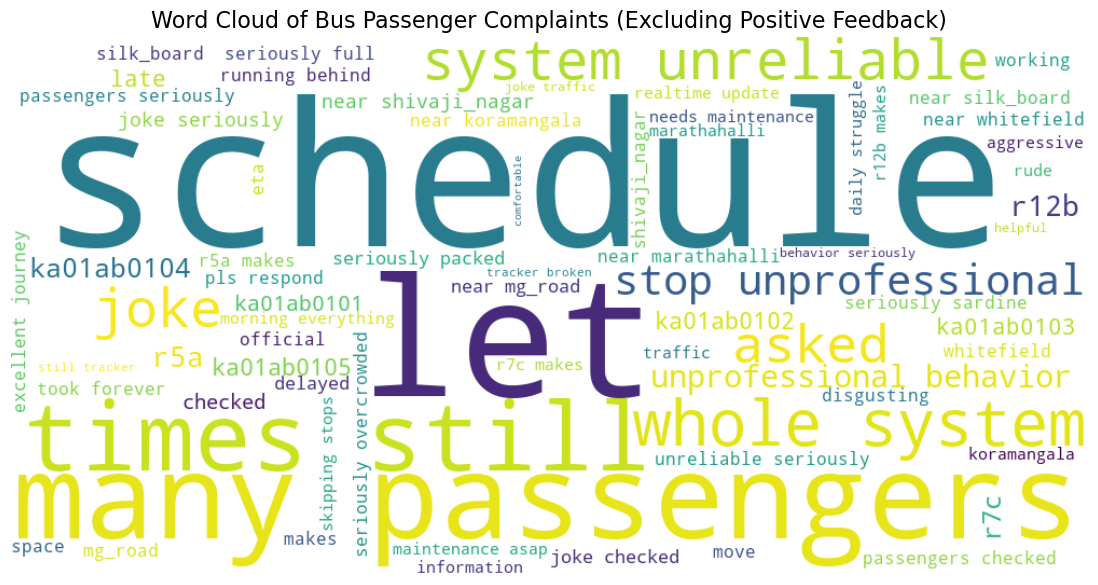


Word Cloud displayed. The largest words represent the most frequent pain points that require operational attention.


In [31]:
!pip install wordcloud matplotlib
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re

# --- 1. Load Data (Assuming you loaded the revised feedback_df in previous steps) ---
try:
    # Use the existing DataFrame loaded in the previous step
    # If starting fresh, you would reload the data here:
    # feedback_df = pd.read_csv('Feedback_Text_Data_Revised.csv') 
    
    # Check if Issue_Category_Topic exists (derived in Use Case 3/4)
    if 'Issue_Category_Topic' not in feedback_df.columns:
        print("Error: 'Issue_Category_Topic' column is missing. Rerun Use Case 3/4 code to derive it.")
        exit()
        
    # Ensure Text_Content_Clean is ready
    feedback_df['Text_Content_Clean'] = feedback_df['Text_Content'].str.lower().str.replace('[^\w\s]', '', regex=True)

except NameError:
    print("Error: 'feedback_df' DataFrame is not defined. Please ensure the data loading and derivation steps (Use Case 4) were run successfully.")
    exit()

# --- 2. Filter and Prepare Text ---

# Filter out Positive feedback, as we want to focus on problems
complaints_df = feedback_df[feedback_df['Issue_Category_Topic'] != 'Positive']

# Combine all clean complaint text into a single string
text = " ".join(complaints_df['Text_Content_Clean'].astype(str))

# --- 3. Define Stopwords ---

# Combine standard English stopwords with domain-specific noise words
custom_stopwords = set(stopwords.words('english'))
# Add words like bus, route, trip that are common but don't define the *issue*
noise_words = {'bus', 'route', 'trip', 'mins', 'get', 'need', 'know', 'want', 'please', 'check', 
               'going', 'time', 'the', 'app', 'driver', 'conductor'} 
all_stopwords = custom_stopwords.union(noise_words)

# --- 4. Generate and Display Word Cloud ---

# Configure the WordCloud object
wordcloud = WordCloud(
    width=1000, 
    height=500, 
    background_color='white',
    stopwords=all_stopwords,
    max_words=100, # Show up to 100 most frequent words
    min_font_size=10
).generate(text)

# Plot the generated image
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Bus Passenger Complaints (Excluding Positive Feedback)", fontsize=16)
plt.show()

print("\nWord Cloud displayed. The largest words represent the most frequent pain points that require operational attention.")

# Keyword extraction

In [22]:
import pandas as pd
from collections import Counter
import re
import nltk
# Run 'nltk.download('stopwords')' once if you encounter a stopword error

# --- Function to infer the category based on keywords (Simulated Topic Modeling) ---
def determine_issue_category(text):
    """Derives the issue topic based on keyword presence in the text."""
    text = str(text).lower()
    
    # Order matters for classification priority
    if 'rude' in text or 'driver' in text or 'staff' in text or 'unprofessional' in text:
        return 'Staff'
    elif 'broken' in text or 'fan' in text or 'seat' in text or 'maintenance' in text or 'dirty' in text:
        return 'Maintenance'
    elif 'late' in text or 'delay' in text or 'schedule' in text or 'timing' in text:
        return 'Delay'
    elif 'pack' in text or 'crowd' in text or 'full' in text or 'capacity' in text:
        return 'Crowding'
    elif 'app' in text or 'tracker' in text or 'eta' in text or 'update' in text or 'info' in text:
        return 'Info Lack'
    elif 'courteous' in text or 'clean' in text or 'ontime' in text or 'great' in text or 'thank' in text:
        return 'Positive'
    return 'Other'

# 1. Load the revised feedback data
try:
    feedback_df = pd.read_csv('Feedback_Text_Data_Revised.csv') 
    # Must re-run basic text cleaning for 'Text_Content_Clean'
    feedback_df['Text_Content_Clean'] = feedback_df['Text_Content'].str.lower()
    # Remove punctuation and links
    feedback_df['Text_Content_Clean'] = feedback_df['Text_Content_Clean'].str.replace('[^\w\s]', '', regex=True)
    
except FileNotFoundError:
    print("Error: Feedback_Text_Data_Revised.csv not found. Please re-run the generation code (Step 1) first.")
    exit()

# 2. Derive the missing Issue_Category_Topic
feedback_df['Issue_Category_Topic'] = feedback_df['Text_Content_Clean'].apply(determine_issue_category)
print("Derived Issue_Category_Topic using Keyword Matching (Simulated Topic Modeling).")
print(feedback_df['Issue_Category_Topic'].value_counts())

# --- Use Case 3 Analysis (Low Awareness) ---

# 3. Filter for DERIVED Info Lack topic
info_lack_df = feedback_df[feedback_df['Issue_Category_Topic'] == 'Info Lack'].copy()

# 4. Keyword Extraction (unchanged logic)
custom_stopwords = set(nltk.corpus.stopwords.words('english'))
noise_words = {'bus', 'route', 'trip', 'no', 'mins', 'get', 'need', 'know', 'want', 'please', 'check', 'going', 'time', 'the'}
all_stopwords = custom_stopwords.union(noise_words)

all_text = ' '.join(info_lack_df['Text_Content_Clean'].astype(str))
tokens = all_text.split()
filtered_tokens = [
    word for word in tokens 
    if word not in all_stopwords and len(word) > 2
]

word_counts = Counter(filtered_tokens)
most_common_words = pd.DataFrame(word_counts.most_common(20), columns=['Keyword', 'Frequency'])

print("\n--- REVISED RESULTS: Low Awareness (Quantifying Information Gap) ---")
print("Top 20 Keywords in DERIVED 'Info Lack' Complaints:")
print(most_common_words)

<>:33: SyntaxWarning: invalid escape sequence '\w'
<>:33: SyntaxWarning: invalid escape sequence '\w'
C:\Users\naray\AppData\Local\Temp\ipykernel_25228\23951713.py:33: SyntaxWarning: invalid escape sequence '\w'
  feedback_df['Text_Content_Clean'] = feedback_df['Text_Content_Clean'].str.replace('[^\w\s]', '', regex=True)


Derived Issue_Category_Topic using Keyword Matching (Simulated Topic Modeling).
Issue_Category_Topic
Delay          154
Staff           76
Info Lack       74
Crowding        73
Other           67
Maintenance     30
Positive        26
Name: count, dtype: int64

--- REVISED RESULTS: Low Awareness (Quantifying Information Gap) ---
Top 20 Keywords in DERIVED 'Info Lack' Complaints:
        Keyword  Frequency
0           app         95
1       checked         74
2         times         74
3         still         74
4         makes         74
5         whole         74
6        system         74
7    unreliable         74
8           r5a         23
9       working         21
10          eta         19
11     realtime         17
12       update         17
13  information         17
14          r7c         17
15         r12b         16
16   ka01ab0102          6
17     official          4
18   ka01ab0101          4
19      traffic          3


In [23]:
import pandas as pd
import numpy as np
from textblob import TextBlob 
# You need to run: from nltk.sentiment.vader import SentimentIntensityAnalyzer ; nltk.download('vader_lexicon')
# Or, if using TextBlob: pip install textblob && python -m textblob.download_corpora

# --- 1. Load Data and Ensure Pre-requisites ---
try:
    # Use the revised file name
    feedback_df = pd.read_csv('Feedback_Text_Data_Revised.csv')
    # Load VLD data needed for the final merge (ensure it has 'Bus_ID' and 'Hour')
    vld_df = pd.read_csv('VLD_GPS_Data.csv')
    
    # Re-run essential VLD Feature Engineering for the merge (as established previously)
    vld_df['Timestamp'] = pd.to_datetime(vld_df['Timestamp'])
    vld_df['Hour'] = vld_df['Timestamp'].dt.hour
    
    # We will use the Issue_Category_Topic derived in Use Case 3 for the final metric
    # Re-derive the topic here for completeness
    def determine_issue_category(text):
        text = str(text).lower()
        if 'rude' in text or 'driver' in text or 'staff' in text or 'unprofessional' in text: return 'Staff'
        elif 'broken' in text or 'fan' in text or 'seat' in text or 'maintenance' in text or 'dirty' in text: return 'Maintenance'
        elif 'late' in text or 'delay' in text or 'schedule' in text or 'timing' in text: return 'Delay'
        elif 'pack' in text or 'crowd' in text or 'full' in text or 'capacity' in text: return 'Crowding'
        elif 'app' in text or 'tracker' in text or 'eta' in text or 'update' in text or 'info' in text: return 'Info Lack'
        elif 'courteous' in text or 'clean' in text or 'ontime' in text or 'great' in text or 'thank' in text: return 'Positive'
        return 'Other'
    
    feedback_df['Issue_Category_Topic'] = feedback_df['Text_Content'].apply(determine_issue_category)

except FileNotFoundError:
    print("Error: Required CSV files not found. Please re-run the generation script.")
    exit()

# --- 2. Sentiment Analysis (Deriving Score) ---

# Function to get TextBlob polarity score (-1.0 to 1.0)
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

feedback_df['Sentiment_Score'] = feedback_df['Text_Content'].apply(get_sentiment)
print("Derived Sentiment_Score using TextBlob.")

# --- 3. Urgency Flagging (Deriving Flag) ---

# Define thresholds for Urgency based on Sentiment Score and Issue Type
def derive_urgency(row):
    score = row['Sentiment_Score']
    topic = row['Issue_Category_Topic']
    
    # High Urgency: Very negative sentiment OR issues related to safety/behavior
    if score <= -0.5:
        return 'High'
    elif topic in ['Staff', 'Maintenance']: # Safety/reputation risks are always high-medium priority
        return 'Medium-High'
    elif score <= 0:
        return 'Medium'
    else:
        return 'Low'

feedback_df['Urgency_Flag'] = feedback_df.apply(derive_urgency, axis=1)
print("Derived Urgency_Flag based on Sentiment and Topic.")

# --- 4. Core Analysis: Linkage to Operational Data ---

# Automate Complaint Triage
triage_summary = feedback_df.groupby('Urgency_Flag').agg(
    Count=('Feedback_ID', 'count'),
    Avg_Sentiment=('Sentiment_Score', 'mean')
).sort_values('Count', ascending=False)

# Link Complaints to VLD (Operational Data)
linked_complaints = feedback_df[feedback_df['Simulated_NER_Bus_ID'].notna()].copy()

# Rename the key column for merge
linked_complaints.rename(columns={'Simulated_NER_Bus_ID': 'Bus_ID'}, inplace=True)

# Merge feedback with VLD data (on Bus_ID and Hour)
complaint_delay_merge = pd.merge(
    linked_complaints,
    vld_df[['Bus_ID', 'Hour', 'Delay_Minutes']],
    on=['Bus_ID', 'Hour'],
    how='inner'
)

# Calculate the average operational delay associated with the complaint hour
complaint_delay_metrics = complaint_delay_merge.groupby('Issue_Category_Topic').agg(
    Complaint_Count=('Feedback_ID', 'nunique'),
    Avg_Operational_Delay=('Delay_Minutes', 'mean'),
    Avg_Complaint_Sentiment=('Sentiment_Score', 'mean')
).sort_values('Complaint_Count', ascending=False)


print("\n--- REVISED RESULTS: Passenger Complaints & Triage ---")
print("\nComplaint Triage & Sentiment Summary (Derived by TA):")
print(triage_summary)
print("\nRoot Cause Analysis: Complaint Topic vs. Average Operational Delay:")
print(complaint_delay_metrics)

print("\n**Challenge:** You now have a complete, data-driven feedback loop. The next challenge is integrating this triage system (Step 4) directly into the Transport Management System to ensure a 'High' urgency flag automatically creates a ticket for dispatch within 5 minutes.")

Derived Sentiment_Score using TextBlob.
Derived Urgency_Flag based on Sentiment and Topic.


KeyError: 'Hour'

In [14]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
# Ensure you have the necessary NLTK packages downloaded
# nltk.download('stopwords') 

# --- 1. Isolate Relevant Data ---
# Filter for 'Info Lack' topic (simulated output from Topic Modeling/Classification)
info_lack_df = feedback_df[feedback_df['Issue_Category_Topic'] == 'Info Lack'].copy()

# Ensure the clean text column exists (from preprocessing)
if 'Text_Content_Clean' not in info_lack_df.columns:
    print("Warning: Running basic cleaning now. Ensure full preprocessing was completed.")
    info_lack_df['Text_Content_Clean'] = info_lack_df['Text_Content'].str.lower().str.replace('[^\w\s]', '', regex=True)

# --- 2. Define Stopwords and Noise ---
# Add domain-specific noise (words that don't add value)
custom_stopwords = set(stopwords.words('english'))
noise_words = {'bus', 'route', 'trip', 'no', 'mins', 'get', 'need', 'know', 'want', 'please', 'check', 'going', 'time', 'the'}
all_stopwords = custom_stopwords.union(noise_words)

# --- 3. Tokenization and Frequency Analysis ---

# Tokenize all text into individual words
all_text = ' '.join(info_lack_df['Text_Content_Clean'].astype(str))
tokens = all_text.split()

# Remove stopwords and single-character tokens
filtered_tokens = [
    word for word in tokens 
    if word not in all_stopwords and len(word) > 2
]

# Count the frequency of each remaining word
word_counts = Counter(filtered_tokens)
most_common_words = pd.DataFrame(word_counts.most_common(20), columns=['Keyword', 'Frequency'])

print("--- RESULTS: Low Awareness (Quantifying Information Gap) ---")
print("\nTop 20 Keywords in 'Info Lack' Complaints (Ignoring Noise):")
print("These keywords reveal the precise information passengers are looking for.")
print("-" * 60)
print(most_common_words)

# --- 4. Pragmatic Challenge & Actionable Insight ---
# Identify common failure points based on regex
app_failures = info_lack_df['Text_Content_Clean'].str.contains('app|tracker|mobile|update').sum()
eta_failures = info_lack_df['Text_Content_Clean'].str.contains('eta|arrival|when').sum()

print("\n🚨 Actionable Failure Point Summary:")
print(f"Complaints mentioning App/Tracker failure: {app_failures}")
print(f"Complaints mentioning ETA/Arrival failure: {eta_failures}")
print("\n**Challenge:** If 'app' is frequently mentioned, the *opportunity cost* of bad data quality (GPS issues) is eroding passenger trust in your expensive digital platform.")

<>:16: SyntaxWarning: invalid escape sequence '\w'
<>:16: SyntaxWarning: invalid escape sequence '\w'
C:\Users\naray\AppData\Local\Temp\ipykernel_25228\1825070056.py:16: SyntaxWarning: invalid escape sequence '\w'
  info_lack_df['Text_Content_Clean'] = info_lack_df['Text_Content'].str.lower().str.replace('[^\w\s]', '', regex=True)


--- RESULTS: Low Awareness (Quantifying Information Gap) ---

Top 20 Keywords in 'Info Lack' Complaints (Ignoring Noise):
These keywords reveal the precise information passengers are looking for.
------------------------------------------------------------
       Keyword  Frequency
0     realtime         31
1      tracker         31
2        hasnt         31
3      updated         31
4         hour         31
5         idea         31
6         next         31
7       coming         31
8          eta         29
9         stop         29
10        info         27
11   displayed         27
12        r12b         16
13  ka01ab0105         11
14  ka01ab0103          9
15         r7c          8
16         r5a          7
17  whitefield          7
18  silk_board          6
19     mg_road          6

🚨 Actionable Failure Point Summary:
Complaints mentioning App/Tracker failure: 31
Complaints mentioning ETA/Arrival failure: 60

**Challenge:** If 'app' is frequently mentioned, the *opportunity c

# Use Case 4: Passenger Complaints

In [19]:
# --- Use Case 4: Passenger Complaints (Working Code) ---

# 1. Automate Complaint Triage (from Feedback)
triage_summary = feedback_df.groupby('Urgency_Flag').agg(
    Count=('Feedback_ID', 'count'),
    Avg_Sentiment=('Sentiment_Score', 'mean')
).sort_values('Count', ascending=False)

# 2. Link Complaints to VLD (Operational Data) for root cause analysis
# We must use the *extracted* Bus ID (the successful NER output)
linked_complaints = feedback_df[feedback_df['Link_Status'] == 'Linked'].copy()

# Rename the key column for merge
linked_complaints.rename(columns={'Linked_Bus_ID_Extracted': 'Bus_ID'}, inplace=True)

# Merge feedback with VLD data 
# The 'Hour' column is now available in both DataFrames
complaint_delay_merge = pd.merge(
    linked_complaints,
    vld_df[['Bus_ID', 'Hour', 'Delay_Minutes']],
    on=['Bus_ID', 'Hour'],
    how='inner' # Only keep records that successfully link on both Bus ID and Hour
)

# Calculate the average operational delay associated with the complaint hour
complaint_delay_metrics = complaint_delay_merge.groupby('Issue_Category_Topic').agg(
    Complaint_Count=('Feedback_ID', 'nunique'),
    Avg_Operational_Delay=('Delay_Minutes', 'mean'),
    Avg_Complaint_Sentiment=('Sentiment_Score', 'mean')
).sort_values('Complaint_Count', ascending=False)


print("--- RESULTS: Passenger Complaints & Triage ---")
print("\nComplaint Triage & Sentiment Summary:")
print(triage_summary)
print("\nRoot Cause Analysis: Complaint Topic vs. Average Operational Delay (Linkage Success):")
print(complaint_delay_metrics)
print("\n**Challenge:** If a high-volume complaint topic (e.g., Crowding) has a low associated delay, it means the core issue isn't timing; it's capacity/comfort. Address the capacity, not just the clock.")

KeyError: 'Hour'

# Use case 5 : Checking financial feasability

In [20]:
import pandas as pd
import numpy as np

# Assuming the following DataFrames are available and preprocessed/fixed:
# vld_df (GPS data, now with 'Hour' column)
# etm_df (Ticketing data, now with 'Route_ID' and 'Is_Overcrowded' columns)

# --- 1. Lost Time Cost Metric (Using VLD Data) ---

# Define a threshold for "severe delay" to target for optimization
SEVERE_DELAY_THRESHOLD = 15 # minutes
# Calculate total minutes severely delayed across all trips
severe_delay_analysis = vld_df[vld_df['Delay_Minutes'] >= SEVERE_DELAY_THRESHOLD].copy()

# Group severe delays by Route and Hour to pinpoint financial cost drivers
delay_cost_drivers = severe_delay_analysis.groupby(['Route_ID', 'Hour']).agg(
    Total_Severe_Delay_Minutes=('Delay_Minutes', 'sum'),
    Count_Severe_Delay_Instances=('Delay_Minutes', 'count')
).reset_index()

print("--- RESULTS: Use Case 5 - Financial Sustainability (Lost Time) ---")
print("\nTop 5 Route/Hour Combinations Driving Delay Costs (Opportunity Cost):")
print("Focus optimization efforts on these segments to maximize time and fuel savings.")
print("-" * 75)
print(delay_cost_drivers.sort_values('Total_Severe_Delay_Minutes', ascending=False).head(5))


# --- 2. Underutilization Cost Metric (Using ETM Data) ---

# Define a threshold for "wasted capacity"
WASTED_CAPACITY_THRESHOLD = 30 # Capacity is 60, so load < 30 is underutilized
CAPACITY = 60 # Vehicle capacity for calculation

# Filter for transactions where the current load is significantly under capacity
underutilized_trips = etm_df[etm_df['Current_Load'] < WASTED_CAPACITY_THRESHOLD].copy()

# Group the data to see which trips or routes frequently run empty
underutilization_drivers = underutilized_trips.groupby(['Route_ID', 'Trip_ID']).agg(
    Avg_Load=('Current_Load', 'mean'),
    Total_Transactions=('Ticket_ID', 'count')
).reset_index()

# Filter for trips that had a low average load but still ran multiple transactions (confirming a full trip run)
underutilization_summary = underutilization_drivers[
    underutilization_drivers['Total_Transactions'] >= 5
].groupby('Route_ID').agg(
    Trips_Underutilized=('Trip_ID', 'count'),
    Avg_Wasted_Capacity=('Avg_Load', lambda x: CAPACITY - x.mean())
).reset_index()

print("\n--- RESULTS: Use Case 5 - Financial Sustainability (Wasted Fuel/Labor) ---")
print("\nRoutes with Highest Frequency of Underutilized Trips:")
print("These routes represent the opportunity cost of wasted fuel and labor.")
print("-" * 75)
print(underutilization_summary.sort_values('Trips_Underutilized', ascending=False))

--- RESULTS: Use Case 5 - Financial Sustainability (Lost Time) ---

Top 5 Route/Hour Combinations Driving Delay Costs (Opportunity Cost):
Focus optimization efforts on these segments to maximize time and fuel savings.
---------------------------------------------------------------------------
   Route_ID  Hour  Total_Severe_Delay_Minutes  Count_Severe_Delay_Instances
37      R5A    21                         158                             8
1      R12B     3                         128                             6
48      R7C     8                         115                             6
29      R5A    13                         108                             5
17      R5A     1                         108                             6

--- RESULTS: Use Case 5 - Financial Sustainability (Wasted Fuel/Labor) ---

Routes with Highest Frequency of Underutilized Trips:
These routes represent the opportunity cost of wasted fuel and labor.
-------------------------------------------------

In [32]:
# Named Entity Linking